In [104]:
# %reload_ext autoreload

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


from trampact.preprocess import get_data, drop_tx_columns
from trampact.plot import draw_hist

In [5]:
# Only run once 
%aimport trampact.preprocess
%aimport trampact.plot
%matplotlib inline

In [108]:
!pwd

/home/primitive/code/eangelid/trampact/notebooks


In [6]:
IRIS_T1_CSV = 'iris_T1.csv'
IRIS_T2_CSV = 'iris_T2.csv'
BD_GENT_2006 = 'BD_GENT_2006.csv'
BD_GENT_2016 = 'BD_GENT_2016.csv'

## Load ALL dataframes

#### Load T1 and T2 IRIS codes
Attn: The `get_data()` method automatically sets `iris_id` as the index

In [7]:
iris_T1 = get_data(IRIS_T1_CSV, is_local_csv=True)

In [8]:
iris_T2__full = get_data(IRIS_T2_CSV, is_local_csv=True)

In [9]:
# drop other columns - only keep index (iris_id) and IRIS label (name)
iris_T2 = pd.DataFrame(iris_T2__full['NOM_IRIS'])

#### Load demographic data

In [10]:
bd_gent_2006 = get_data(BD_GENT_2006, is_local_csv=True)

In [11]:
bd_gent_2016 = get_data(BD_GENT_2016, is_local_csv=True)

## Imputing
Do it here before creating new dataframes

#### Take a look at NULL values
Low percentage. We can get away with median (?)

In [115]:
bd_gent_2006.isnull().sum().sort_values(ascending=False) #NaN count for each column
bd_gent_2006.isnull().sum().sort_values(ascending=False)/len(bd_gent_2006) #NaN percentage for each column

rev_2006                0.048
t_actifs_2006           0.000
tx_voit_2006            0.000
tx_chom_2006            0.000
tx_empl_2006            0.000
tx_ouvr_2006            0.000
tx_TP_2006              0.000
tx_HLM_2006             0.000
tx_no_transp_2006       0.000
tx_walk_2006            0.000
tx_moto_2006            0.000
tx_TC_2006              0.000
HH_2voit_2006           0.000
tx_HH_moins2ans_2006    0.000
tx_HH_2_4ans_2006       0.000
tx_HH_5_9ans_2006       0.000
tx_HH_plus10ans_2006    0.000
tx_HH_with_park_2006    0.000
tx_HH_with_voit_2006    0.000
tx_HH_1voit_2006        0.000
tx_HH_2voit_2006        0.000
pop_2006                0.000
HH_1voit_2006           0.000
t_chom_2006             0.000
walk_2006               0.000
empl_2006               0.000
ouvrier_2006            0.000
TP_2006                 0.000
Int_2006                0.000
app_stage_2006          0.000
cdd_2006                0.000
HLM_2006                0.000
no_transp_2006          0.000
moto_2006 

In [116]:
bd_gent_2016.isnull().sum().sort_values(ascending=False) #NaN count for each column
bd_gent_2016.isnull().sum().sort_values(ascending=False)/len(bd_gent_2016) #NaN percentage for each column

rev_2016                0.054
tx_empl_prec_2016       0.002
tx_voit_2016            0.002
tx_chom_2016            0.002
tx_empl_2016            0.002
tx_ouvr_2016            0.002
tx_TP_2016              0.002
tx_HLM_2016             0.002
tx_no_transp_2016       0.002
tx_walk_2016            0.002
tx_moto_2016            0.002
tx_TC_2016              0.002
tx_HH_moins2ans_2016    0.002
tx_HH_2_4ans_2016       0.002
tx_HH_5_9ans_2016       0.002
tx_HH_plus10ans_2016    0.002
tx_HH_with_park_2016    0.002
tx_HH_with_voit_2016    0.002
tx_HH_1voit_2016        0.002
tx_HH_2voit_2016        0.002
HH_2voit_2016           0.000
pop_2016                0.000
t_actifs_2016           0.000
t_chom_2016             0.000
walk_2016               0.000
empl_2016               0.000
ouvrier_2016            0.000
TP_2016                 0.000
Int_2016                0.000
app_stage_2016          0.000
CDD_2016                0.000
HLM_2016                0.000
no_transp_2016          0.000
moto_2016 

In [12]:
rev_2006_mean_before = bd_gent_2006['rev_2006'].mean()

simp_imputer = SimpleImputer(strategy="mean")

simp_imputer.fit(bd_gent_2006[['rev_2006']])

bd_gent_2006['rev_2006'] = simp_imputer.transform(bd_gent_2006[['rev_2006']])

print(f'rev_2006 - mean: Before {rev_2006_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2006 - mean: Before 17310.4737394958 , After17310.4737394958


In [13]:
rev_2016_mean_before = bd_gent_2016['rev_2016'].mean()

simp_imputer = SimpleImputer(strategy="mean")

simp_imputer.fit(bd_gent_2016[['rev_2016']])

bd_gent_2016['rev_2016'] = simp_imputer.transform(bd_gent_2016[['rev_2016']])

print(f'rev_2016 - mean: Before {rev_2016_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2016 - mean: Before 21324.373848523497 , After21324.373848523497


#### Merge datadrames to get T1 quarters ONLY

In [14]:
# bd_gent_2006_T1 = bd_gent_2006.merge(iris_T1, on='iris_id').drop('NOM_IRIS', axis=1)
bd_gent_2006_T1 = bd_gent_2006.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

In [15]:
bd_gent_2016_T1 = bd_gent_2016.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

#### Drop columns with ratios - We do not always need them

In [16]:
bd_gent_2006_no_tx = drop_tx_columns(bd_gent_2006, '2006')

In [17]:
bd_gent_2016_no_tx = drop_tx_columns(bd_gent_2016, '2016')

In [18]:
bd_gent_2006_T1_no_tx = drop_tx_columns(bd_gent_2006_T1, '2006')

In [19]:
bd_gent_2016_T1_no_tx = drop_tx_columns(bd_gent_2016_T1, '2016')

<hr>

<hr>

## Check dataframes
🚨(no need to run this part if not the first time loading the data frames)🚨

In [20]:
iris_T1.head()

,NOM_IRIS
iris_id,
60881304,Saint-Sylvestre
60881503,Jeanne d'Arc-Fuon-Cauda
60881303,Gorbella
60881505,Michelet
60881302,Saint-Barthelemy


In [21]:
iris_T2.head()

,NOM_IRIS
iris_id,
61230107,Centre Ville
61230103,Les Pomarels
61230102,Les Paluds
61230101,Le Lac
60883102,Parc des Sports


In [127]:
bd_gent_2006

,t_actifs_2006,t_chom_2006,empl_2006,ouvrier_2006,TP_2006,Int_2006,app_stage_2006,cdd_2006,rev_2006,HLM_2006,...,tx_TC_2006,tx_HH_moins2ans_2006,tx_HH_2_4ans_2006,tx_HH_5_9ans_2006,tx_HH_plus10ans_2006,tx_HH_with_park_2006,tx_HH_with_voit_2006,tx_HH_1voit_2006,tx_HH_2voit_2006,tx_empl_prec_2006
iris_id,,,,,,,,,,,,,,,,,,,,,
60010000,32.377778,2.088889,8.355556,0.000000,6.266667,0.000000,0.000000,8.355556,17465.000000,0.000000,...,12.903226,12.903226,29.032258,22.580645,83.870969,80.645160,122.580645,74.193547,48.387097,25.806453
60020000,12.008551,3.002138,4.002850,4.002850,1.000713,0.000000,0.973333,0.000000,17310.473739,0.000000,...,0.000000,25.000002,33.333331,16.666665,58.333333,66.666669,133.333331,108.333328,25.000002,8.105335
60030000,232.021978,24.725275,51.282051,80.586081,32.967033,0.915751,3.622305,28.388278,13866.000000,56.776557,...,0.000000,24.111964,22.533232,20.918190,28.058792,58.413059,86.544473,56.081273,30.463200,14.191041
60040101,558.359852,79.552998,189.506664,142.278837,104.191062,0.000000,9.724609,43.918480,20108.000000,0.000000,...,12.450518,3.569231,13.748829,9.705411,36.637534,48.238210,61.290878,30.845691,30.445187,9.607261
60040102,1322.676650,95.706717,453.856986,188.318276,203.919192,11.170277,17.151069,81.122892,18178.000000,414.223503,...,5.740664,5.073478,11.192460,16.480261,42.846445,52.077781,70.229033,33.934914,36.294119,8.274451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61610105,1070.143140,121.898065,397.279573,178.515334,143.177166,18.322224,22.206448,115.237998,19142.000000,0.000000,...,8.011063,18.335151,27.809770,19.759057,24.424479,73.224939,80.407723,52.768587,27.639137,14.555685
61610106,1645.359183,123.637177,436.479269,108.135220,192.168782,0.000000,22.544785,56.407980,25920.000000,0.000000,...,5.125699,12.007601,24.526872,22.326242,32.991252,84.775092,88.932230,42.424481,46.507749,4.798512
61610107,1213.893134,147.245491,327.999513,187.255870,168.828448,23.063141,28.794645,75.451976,20366.000000,0.000000,...,3.158645,13.532242,18.841655,18.139616,38.239992,72.622501,80.852761,48.719325,32.133435,10.487724


In [128]:
bd_gent_2016

,t_actifs_2016,t_chom_2016,empl_2016,ouvrier_2016,TP_2016,Int_2016,app_stage_2016,CDD_2016,rev_2016,HLM_2016,...,tx_TC_2016,tx_HH_moins2ans_2016,tx_HH_2_4ans_2016,tx_HH_5_9ans_2016,tx_HH_plus10ans_2016,tx_HH_with_park_2016,tx_HH_with_voit_2016,tx_HH_1voit_2016,tx_HH_2voit_2016,tx_empl_prec_2016
iris_id,,,,,,,,,,,,,,,,,,,,,
60010000,36.365591,5.741935,4.784946,0.000000,6.698925,0.000000,0.000000,1.913978,21324.373849,0.000000,...,26.315789,28.947368,28.947368,21.052632,47.368421,73.684211,110.526316,73.684211,36.842105,5.263158
60020000,31.146667,5.840000,4.866667,4.866667,6.813333,0.000000,0.973333,5.840000,21324.373849,0.000000,...,0.000000,15.625000,25.000000,12.500000,68.750000,34.375000,90.625000,65.625000,25.000000,21.875000
60030000,269.050007,43.467660,95.085507,67.918219,42.562084,1.811153,3.622305,18.111525,15670.000000,59.768033,...,0.000000,11.443818,23.560802,24.268852,41.063111,69.707541,93.941508,52.205231,41.736277,8.751155
60040101,604.818909,96.239886,183.644202,102.723350,53.893508,3.788325,9.724609,40.522157,21136.000000,284.838873,...,9.189947,13.618267,38.343338,33.730176,18.561670,75.119975,80.093156,55.589045,24.504111,8.934094
60040102,1265.456645,91.799759,341.483429,157.342286,152.709438,1.142076,17.151069,81.025567,24220.000000,298.156364,...,5.396948,6.232465,14.154485,8.492861,52.291805,58.982592,76.012828,39.134568,36.878260,7.848448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61610105,1621.893402,232.947500,511.231363,205.952640,196.506069,10.711922,22.206448,83.450704,22144.000000,381.366408,...,5.203822,14.854872,29.923644,23.215319,27.771439,82.611092,85.787068,59.528096,26.258972,7.174890
61610106,1466.420317,116.411129,351.712682,143.043448,266.249480,4.170535,22.544785,72.856268,29904.000000,31.320072,...,3.602346,11.217134,18.171586,20.946745,52.668838,92.484577,98.777850,51.756278,47.021572,6.790112
61610107,1273.409492,155.832040,394.800496,196.862009,169.677854,9.716450,28.794645,72.845994,25316.000000,8.460374,...,2.814499,14.185671,19.073139,15.571819,37.812326,77.380794,82.406818,52.260912,30.145906,8.744798


In [129]:
print(bd_gent_2006.shape)

(500, 44)


In [130]:
print(bd_gent_2016.shape)

(500, 44)


In [131]:
print(bd_gent_2006_T1.shape)

(35, 44)


In [132]:
print(bd_gent_2016_T1.shape)

(35, 44)


In [133]:
print(bd_gent_2006_no_tx.shape)

(500, 25)


In [134]:
print(bd_gent_2016_no_tx.shape)

(500, 25)


<hr>

## Draw histograms - compare 2006 to 2016 and Nice vs. T1/T2

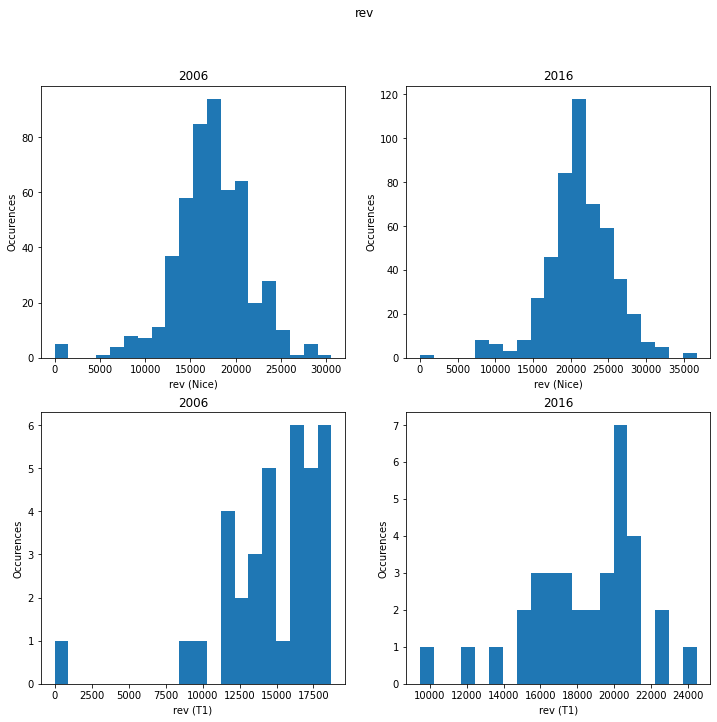

In [22]:
feature_label = 'rev'
draw_hist(bd_gent_2006, bd_gent_2016, bd_gent_2006_T1, bd_gent_2016_T1, feature_label)

## Pearson correlation 🚀

In [ ]:
corr = bd_gent_2006_T1_no_tx.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(15,16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [ ]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.reset_index(inplace=True, drop=True)
corr_df.head()

## Pairplots

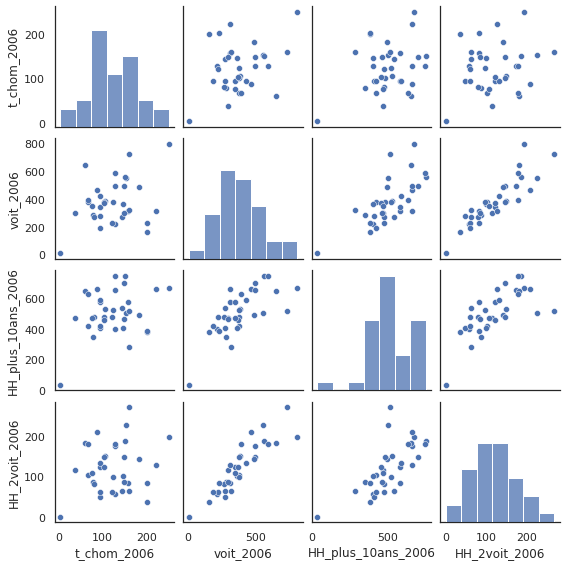

In [23]:
sns.set(style='white')
sns.pairplot(bd_gent_2006_T1_no_tx[['t_chom_2006', 'voit_2006', 'HH_plus_10ans_2006', 'HH_2voit_2006']], height=2)
plt.show()

## Time for a bit of modelling

### Model parameters - Chage these to dig into e.g. Nice or just T1 or 2006 vs 2016


In [24]:
df__X = bd_gent_2016_no_tx

In [25]:
scaler = StandardScaler()
df__X__scaled = pd.DataFrame(scaler.fit_transform(df__X))

In [26]:
pca = PCA()

In [27]:
pca.fit(df__X__scaled)

PCA()

In [28]:
Wt = pd.DataFrame(pca.components_)

In [29]:
df__X__scaled_PCA = pd.DataFrame(pca.transform(df__X__scaled))

<AxesSubplot:>

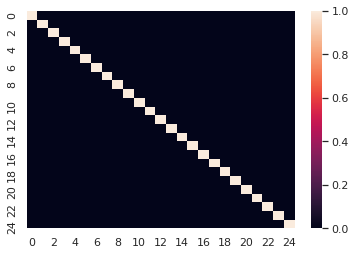

In [30]:
sns.heatmap(df__X__scaled_PCA.corr())

In [31]:
numpy__X__scaled_PCA = df__X__scaled_PCA.to_numpy(copy=True) # What was the problem? Wrong datatype expected=numpy, passed:pd.DataFrame

df = pd.DataFrame()
df["vif_index"] = [vif(numpy__X__scaled_PCA, i) for i in range(numpy__X__scaled_PCA.shape[1])]

In [ ]:
df

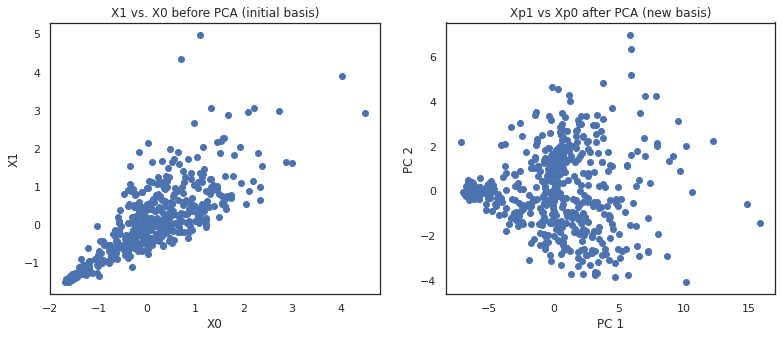

In [32]:
numpy__X__scaled = df__X__scaled.to_numpy()

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial basis)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(numpy__X__scaled[:,0], numpy__X__scaled[:,1])

plt.subplot(1,2,2)
plt.title('Xp1 vs Xp0 after PCA (new basis)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1])

In [145]:
#'Rank' PC per order of 'importance'
df_Xp = df__X__scaled_PCA # sample: pd.DataFrame(Xp)
df_Xp.std()**2 / ((df_Xp.std()**2).sum())

0     6.340240e-01
1     1.247998e-01
2     6.249376e-02
3     3.377816e-02
4     2.719190e-02
5     2.311094e-02
6     1.907207e-02
7     1.455587e-02
8     1.335200e-02
9     1.034494e-02
10    8.495853e-03
11    5.612497e-03
12    4.776744e-03
13    4.580662e-03
14    3.572941e-03
15    3.017428e-03
16    2.132601e-03
17    1.864649e-03
18    1.411568e-03
19    8.493884e-04
20    4.828774e-04
21    4.443682e-04
22    3.494276e-05
23    4.386593e-21
24    3.254291e-21
dtype: float64

In [146]:
pca.explained_variance_ratio_

array([6.34024015e-01, 1.24799830e-01, 6.24937561e-02, 3.37781562e-02,
       2.71918953e-02, 2.31109404e-02, 1.90720741e-02, 1.45558739e-02,
       1.33519961e-02, 1.03449438e-02, 8.49585335e-03, 5.61249686e-03,
       4.77674422e-03, 4.58066165e-03, 3.57294064e-03, 3.01742845e-03,
       2.13260089e-03, 1.86464874e-03, 1.41156773e-03, 8.49388392e-04,
       4.82877408e-04, 4.44368191e-04, 3.49427568e-05, 4.38659334e-21,
       3.25429084e-21])

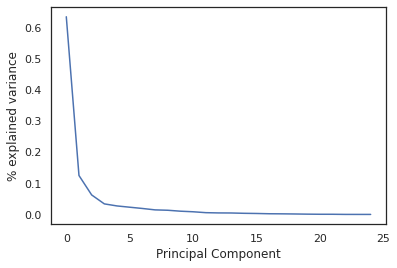

In [33]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

In [34]:
eig_vals, eig_vecs = np.linalg.eig(np.dot(df__X__scaled.T,df__X__scaled))

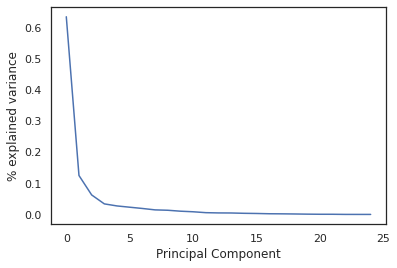

In [35]:
# Compute the share of explained variance per component
tot = sum(eig_vals)
share_of_variances = [(i / tot) for i in sorted(eig_vals, reverse=True)]
plt.plot(share_of_variances); 
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

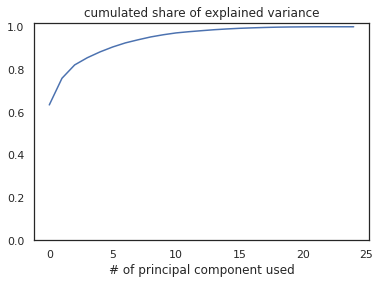

In [36]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [37]:
y_pred = df__X__scaled[24]

# model = LogisticRegression()
from sklearn.linear_model import LinearRegression
model = LinearRegression()

print("accuracy all features")
cross_val_score(model, df__X__scaled, y_pred, cv=10).mean()

accuracy all features


1.0

In [153]:
#
# !--- HERE!!!! Type the number of components that PCA found or you want to use ---!
#
n_components = 2

In [154]:
pca2 = PCA(n_components).fit(df__X__scaled)

# Print our 2 principal components
pd.DataFrame(pca2.components_)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.24557,0.216039,0.236617,0.209056,0.233958,0.157891,0.180272,0.222301,0.028275,0.091775,...,0.244547,0.198953,0.226004,0.233491,0.230649,0.216581,0.235088,0.230436,0.164058,0.246702
1,-0.07110,0.181658,0.075158,0.147860,-0.045065,0.248681,-0.000439,0.098895,-0.459462,0.242940,...,-0.004777,0.108350,0.071186,0.022706,-0.090220,-0.239729,-0.179124,0.015893,-0.382374,-0.045319


In [155]:
X__pca__2 = pca2.fit_transform(df__X__scaled)

In [156]:
pd.DataFrame(X__pca__2)

,0,1
0,-6.758376,-0.134601
1,-6.833703,-0.087770
2,-5.101420,0.318347
3,-2.602087,0.067142
4,0.456624,-1.843673
...,...,...
495,4.107194,-0.702343
496,3.342883,-3.693500
497,1.640294,-1.730081
498,-4.928702,-0.305038


In [157]:
print(f"accuracy {n_components} features")
cross_val_score(model, X__pca__2, y_pred, cv=10).mean()

accuracy 2 features


0.9344638241885432

In [158]:
# Keep only 1 dimension
pca1 = PCA(n_components=1)

X__pca__1 = pca1.fit_transform(df__X__scaled) # Reminder: df__X_scaled == bd_gent_20??_no_tx__scaled

pd.DataFrame(X__pca__1)
print("accuracy 1 features")
cross_val_score(model, X__pca__1, y_pred, cv=10).mean()

accuracy 1 features


0.9370067005938465

# KMeans

In [159]:
#
# !--- HERE!!!! Type the number of components you want to use ---!
#
n_clusters = 2
# n_clusters = n_components

In [160]:
km = KMeans(n_clusters)
km.fit(df__X__scaled_PCA)

KMeans(n_clusters=2)

In [161]:
km.cluster_centers_

array([[-4.49292473e+00, -8.22249123e-04,  1.98886662e-01,
         5.25605897e-02,  6.12344827e-02, -3.40535055e-02,
        -4.76697474e-02,  8.85222114e-02,  4.51522421e-02,
        -3.19164684e-02,  1.51194000e-02,  3.76597762e-02,
        -1.89028314e-02,  5.56986808e-03,  4.96931951e-03,
        -1.12330795e-02, -6.32873274e-03,  4.99008085e-04,
        -1.54036992e-03, -1.01027486e-03,  9.14924182e-04,
         1.10562040e-02, -1.65566546e-03,  1.49374647e-11,
         3.41218292e-13],
       [ 2.15341363e+00,  3.94095733e-04, -9.53243764e-02,
        -2.51917619e-02, -2.93490716e-02,  1.63215026e-02,
         2.28476304e-02, -4.24278055e-02, -2.16410154e-02,
         1.52972423e-02, -7.24657634e-03, -1.80499519e-02,
         9.05993696e-03, -2.66958174e-03, -2.38174486e-03,
         5.38390200e-03,  3.03329794e-03, -2.39169556e-04,
         7.38283806e-04,  4.84214577e-04, -4.38513957e-04,
        -5.29912737e-03,  7.93543800e-04, -7.15937155e-12,
        -1.63547310e-13]])

In [162]:
km.labels_

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [38]:
numpy__X__scaled_PCA = df__X__scaled_PCA.to_numpy()

plt.figure(figsize=(12,4))
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=km.labels_)
plt.title('KMeans clustering'); 
plt.xlabel('PC 1');
plt.ylabel('PC 2')

NameError: name 'km' is not defined

Text(0.5, 1.0, 'True classification')

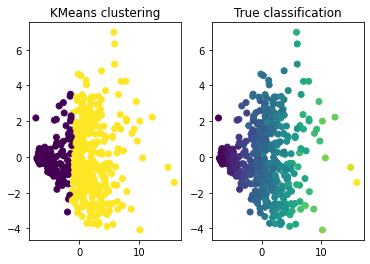

In [164]:
plt.subplot(1,2,1)
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=km.labels_)
plt.title('KMeans clustering')

plt.subplot(1,2,2)
plt.scatter(numpy__X__scaled_PCA[:,0], numpy__X__scaled_PCA[:,1], c=y_pred)
plt.title('True classification')

In [ ]:
# ?????
km.predict(new_X)

In [ ]:
inertias = []
ks = range(1,10)
for k in ks:
    km_test = KMeans(n_clusters=k).fit(df__X__scaled_PCA)
    inertias.append(km_test.inertia_)
plt.plot(ks, inertias)
plt.xlabel('k cluster number')

In [166]:
len(km.labels_)

500

In [167]:
km.labels_

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,